In [4]:
# recall df
%store -r w_df
%store -r w_test
%store -r w_train

PAKAGES

In [3]:
import numpy as np
import pandas as pd
import math
import statistics
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns


# for pattern identification 
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy import signal

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# Describing the time series patterns (visually and numerically)

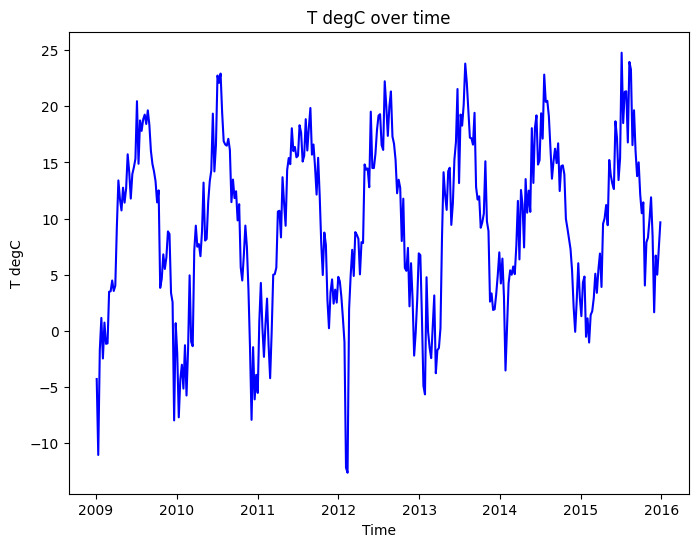

In [8]:
# Since in the next point we are interested in make forecasting about the variable degC
# we only take this in consideration even in this session in which we analyse the series patterns

t_degC_df=w_train['T (degC)']

# we also plot it 
plt.figure(figsize=(8,6))
plt.plot(t_degC_df,color='Blue')
plt.xlabel('Time')
plt.ylabel('T degC')
plt.title('T degC over time')
plt.show()

So from a first look we can notice a seasonal patterns in this series that can also cover eventual trend and cycle component.
But before analyze seasonality, we want to analyze if the time series is stationaty.

## Stationarity

Stationarity in a time series means that its statistical properties (mean, variance, and autocorrelation) remain constant over time.
Non-stationary series can lead to unreliable model predictions, invalid statistical tests, and spurious correlations.

So we can check it following:

In order to check for the stationarity of a time series, different operations and statistical tests can be done, in particular:

* evaluating rolling statistics (generally mean and standard deviation --> should be stable);
* ACF plot: for a stationary time series the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly;
* Unit root tests: these are statistical hypothesis tests of stationarity that are designed for determining whether differencing is required. ADF (Augmented Dickey-Fuller) and * * KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests are the main ones.

### Rolling statistics

Rolling Statistics is a method that calculates rolling statistics (such as the mean and standard deviation) over a specific time window, which moves across the time series data. Used to observe how the statistical properties (mean and standard deviation) change over time.

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

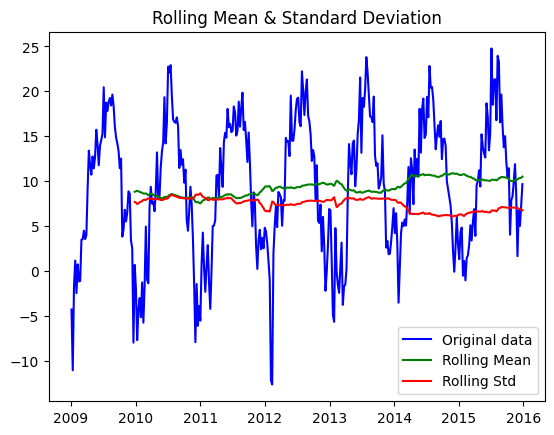

In [12]:
# since the data are weeakely the parameter are the number of the week in one year 52
rolling_mean = t_degC_df.rolling(52).mean()
rolling_std = t_degC_df.rolling(52).std()
plt.plot(t_degC_df, label='Original data',color='Blue')
plt.plot(rolling_mean, color='green', label='Rolling Mean')
plt.plot(rolling_std, color='red', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

# Rolling mean and std have a constant behaviour over the years, indeed even if they change over the year this behaviour is then repeated next year.
# This hints towards stationarity

We can see that the mean and variance **have not** high oscillation, but we have it, seams to me similar over time.
This allowed us to think that we colund have a **not stationary** time series since even if the oscillation are small, are present.

But we try other method

### ACF plot
for a stationary time series the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly

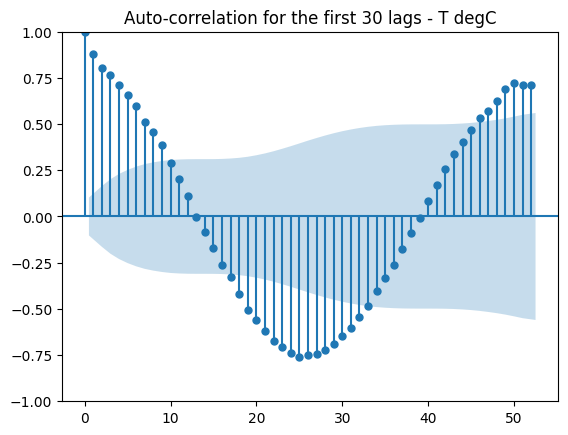

In [15]:
# as lag i still put the numeber of weeks
plot_acf(t_degC_df, lags=52, title='Auto-correlation for the first 30 lags - T degC')
plt.show()

The series is not stationary, because:

* Autocorrelation does not decay rapidly.
* Cyclical or seasonal patterns are observed.
* Significant correlations persist for many lags.

### Unit root tests: ADF (Augmented Dickey-Fuller) - KPSS (Kwiatkowski-Phillips-Schmidt-Shin) 

 these are statistical hypothesis tests of stationarity that are designed for determining whether differencing is required. 

In [17]:
#Execute an AdFuller test on the data. If the p-value is less than <=0.05 the data is stationary, otherwise it is not.
def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')

#Execute a KPSS test on the data passed by the argument. If the p-value is less than 0.05 then null hypothesis cannot be rejected
# and that's means the data is not trend stationary, otherwise is trend stationary.
def kpss_test(data):
  kpss_out = kpss(data,regression='ct', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')


###############################################
adfuller_test(t_degC_df)
print('----------------------')
kpss_test(t_degC_df)

ADF Statistic: -7.945514086336788
p-value:  3.2279831966229144e-12
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
We can reject the null hypothesis (H0) --> data is stationary
----------------------
KPSS Statistic: 0.020274605447635607
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


C:\Users\lovoa\AppData\Local\Temp\ipykernel_19512\348044341.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_out = kpss(data,regression='ct', nlags='auto', store=True)


it seems that grafically and tests givs us contradittory results, that can be given from the fact that we have strong seasonal component in the data.

# da vedere meglio